<a href="https://colab.research.google.com/github/drcnavad/MelanomaDetectionCNN/blob/main/SkinCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem statement: 
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Dataset:
The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). The data set contains the following diseases:
Actinic keratosis, Basal cell carcinoma, Dermatofibroma, Melanoma, Nevus, Pigmented benign keratosis, Seborrheic keratosis, Squamous cell carcinoma, and Vascular lesion

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## Google drive mount
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


### Data preparation

In [3]:

# Defining the path for train and test images
train_path = '/content/drive/MyDrive/ColabNotebooks/SkinCancer/Train'
test_path = '/content/drive/MyDrive/ColabNotebooks/SkinCancer/Test'

# Update the paths to represent the train_path and test_path directory where images are located.
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'Total images in training dataset: {image_count_train}')

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'Total images in testing dataset: {image_count_test}')

Total images in training dataset: 2239
Total images in testing dataset: 118


In [5]:
#parameters for the load
batch_size = 32
img_height = 180
img_width = 180
input_shape = (img_height,img_width, 3)

#Let's use 80% of images for training and 20% for validation from training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, 
                                                               image_size=(img_height, img_width), validation_split=0.2, 
                                                               subset="training", batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, 
                                                               image_size=(img_height, img_width), validation_split=0.2, 
                                                               subset="validation", batch_size=batch_size)

# class names and number of classes in the dataset
class_names = train_ds.class_names
num_classes = len(class_names)

print("Class names:", class_names)
print("Number of classes:", num_classes)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes: 9


In [13]:
# check the shape of the image and label
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Visualization

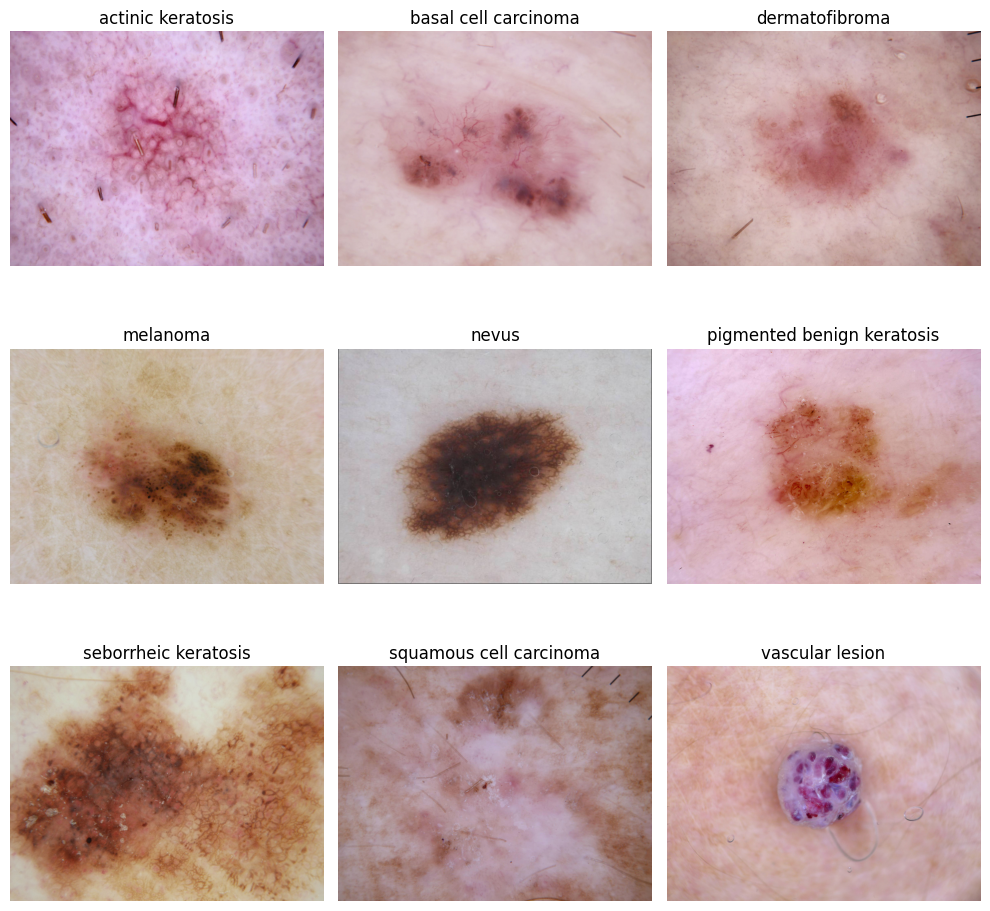

In [7]:
class_names = train_ds.class_names

# Create a figure to display the images
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

# Visualize one image from each class
for i, class_name in enumerate(class_names):
    img_path = str(data_dir_train/class_name/'*.jpg')
    img = PIL.Image.open(str(list(data_dir_train.glob(f'{class_name}/*.jpg'))[0]))
    axs[i].imshow(img)
    axs[i].set_title(class_name)
    axs[i].axis("off")

plt.tight_layout()
plt.show()



In [8]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,squamous cell carcinoma,181
2,nevus,357
3,actinic keratosis,114
4,dermatofibroma,95
5,seborrheic keratosis,77
6,melanoma,438
7,basal cell carcinoma,376
8,pigmented benign keratosis,462


<Axes: xlabel='No. of Image', ylabel='Class'>

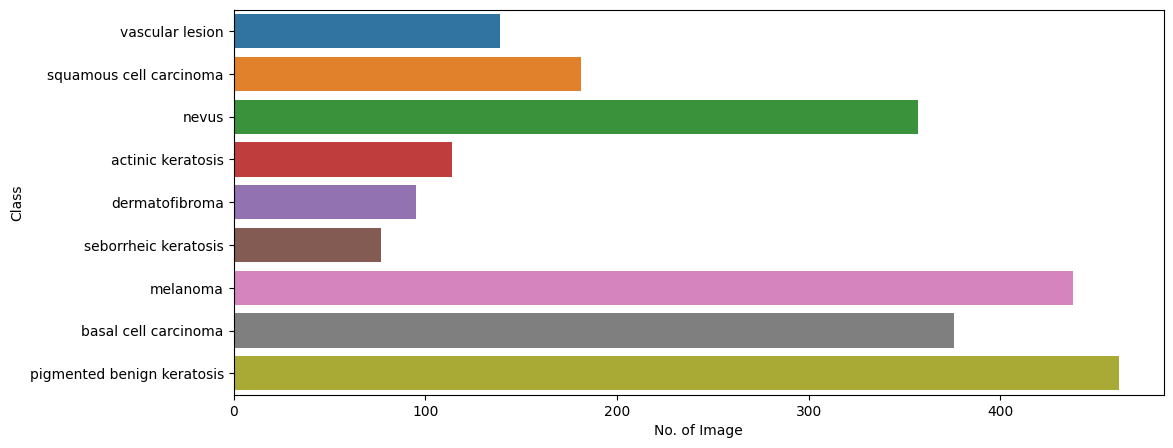

In [12]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [14]:
'''
## Note: The image_batch is a tensor of the shape (32, 180, 180, 3) where 32 is batch size of images.
## Note: Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This speeds up the training.
## Note: Dataset.prefetch() method is called to prefetch data to the GPU or CPU in the background while the model is training.
This helps to reduce the idle time spent waiting for data to arrive, leading to improved training performance..
'''

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN Models

#### 1. Base Model using Keras

In [15]:
#Normalize pixel values between (0,1) bcoz RGB values are in (0,255) range.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape)

# We can also perform transfer learning using ResNet or others pretrained models, however, we will build our own model from scratch. 

# Create a base model
model = Sequential([
normalization_layer,
layers.Conv2D(32, kernel_size = (3,3), activation='relu'),  #first convulational layer, default padding = 'same', 
layers.MaxPooling2D(),         # default poolsize = 2x2
layers.Conv2D(64, kernel_size = (3,3), activation='relu'),  #second convulational layer
layers.MaxPooling2D(),
layers.Conv2D(128, kernel_size = (3,3), activation='relu'),  #third convulational layer
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(256, activation='relu'),    # dense layer
layers.Dense(128, activation='relu'),    # dense layer
layers.Dense(len(class_names), activation='softmax') # output layer, Softmax scales numbers/logits into probabilities.
])

In [16]:
# Compile
model.compile(optimizer='adam', #Adam is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #categorical crossentropy for multiclass output labels
metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 194s 3s/step - loss: 1.9474 - accuracy: 0.2879 - val_loss: 1.6602 - val_accuracy: 0.4027
Epoch 2/20
56/56 [==============================] - 157s 3s/step - loss: 1.6145 - accuracy: 0.4208 - val_loss: 1.5131 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 174s 3s/step - loss: 1.4611 - accuracy: 0.4827 - val_loss: 1.4182 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 165s 3s/step - loss: 1.3705 - accuracy: 0.5212 - val_loss: 1.5204 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 156s 3s/step - loss: 1.3173 - accuracy: 0.5301 - val_loss: 1.4266 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 162s 3s/step - loss: 1.2125 - accuracy: 0.5737 - val_loss: 1.4257 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 159s 3s/step - loss: 1.2009 - accuracy: 0.5714 - val_loss: 1.4692 - val_accuracy: 0.5235
Epoch 8/20
56

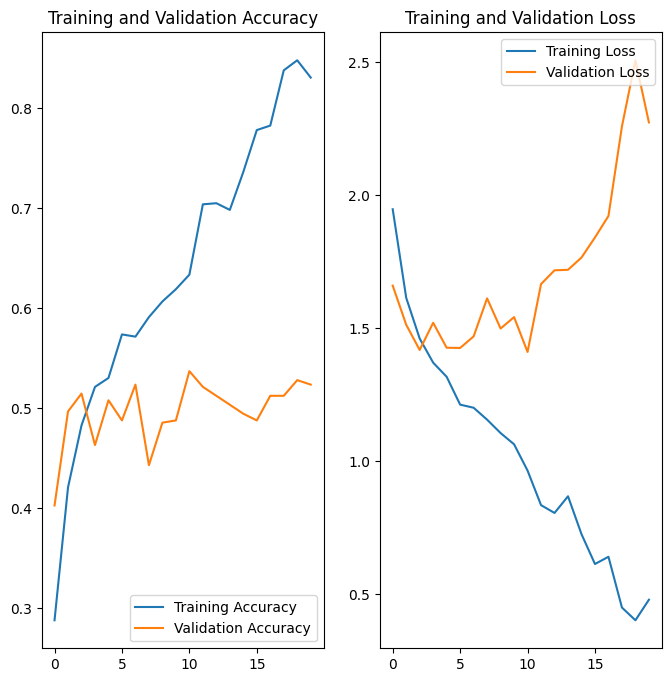

In [ ]:
#Visualize the model performance 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#Accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The models accuracy on the training data set is 85% on 20 epochs, but its accuracy on the validation data set is only 52%. This clearly indicates that the model will overfit on unseen data. Additionally, the validation loss is much higher than the training loss, further supporting the conclusion that the model is overfitting.

#### Image Augmentation - Using ImageDataGenerator (for demonstration only)

In [ ]:
#Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,  
    zoom_range=0.2, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# history = model.fit(train_generator,
#           steps_per_epoch=len(train_generator),
#           epochs=20,
#           validation_data=validation_generator,
#           validation_steps=len(validation_generator))

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


#### Image Augmentation - Using Keras Layers

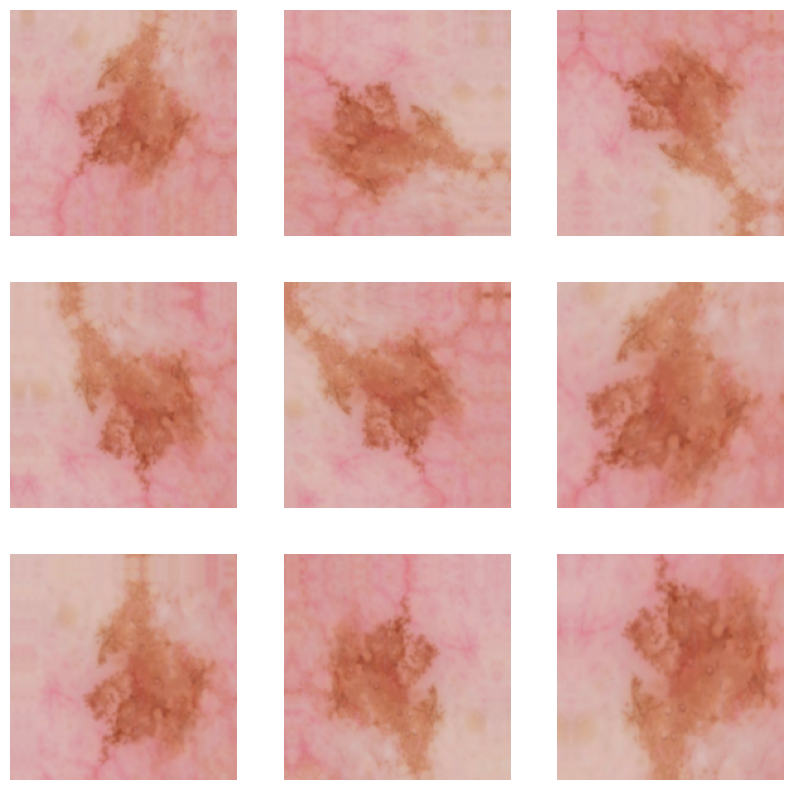

In [17]:
#Augmentation using Keras layers can be added directly into model building
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
    ]
)

# plot one of the augumented image versions
image, label = next(iter(train_ds))

image = np.array(image,np.int32)
plt.figure(figsize=(10,10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augumented_image1 = np.array(augmented_image[0],np.int32)
  plt.imshow(augumented_image1)
  plt.axis('off')

2. Model after Image Augmentation

In [18]:
#image augmentation may help with overfitting issues

# Create the model

model2 = Sequential([
normalization_layer,
data_augmentation,
layers.Conv2D(32, kernel_size = (3,3), activation='relu'),  #first convulational layer, default padding = 'same', 
layers.MaxPooling2D(),         # default poolsize = 2x2
layers.Dropout(0.20),  #Dropout layer with 20% Fraction of the input units to drop

layers.Conv2D(64, kernel_size = (3,3), activation='relu'),  #second convulational layer
layers.MaxPooling2D(),

layers.Conv2D(128, kernel_size = (3,3), activation='relu'),  #third convulational layer
layers.MaxPooling2D(),
layers.Dropout(0.20),  #Dropout layer with 20% Fraction of the input units to drop

layers.Flatten(),

layers.Dense(256, activation='relu'),    # dense layer
layers.Dense(128, activation='relu'),    # dense layer
layers.Dense(len(class_names), activation='softmax') # output layer, Softmax scales numbers/logits into probabilities.
])

# Compile
model2.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

In [19]:
# Train the model
epochs = 20
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 153s 830ms/step - loss: 1.9682 - accuracy: 0.2470 - val_loss: 1.6245 - val_accuracy: 0.3860
Epoch 2/20
169/169 [==============================] - 10s 57ms/step - loss: 1.6119 - accuracy: 0.3785 - val_loss: 1.5632 - val_accuracy: 0.4009
Epoch 3/20
169/169 [==============================] - 10s 58ms/step - loss: 1.5241 - accuracy: 0.4115 - val_loss: 1.4970 - val_accuracy: 0.4232
Epoch 4/20
169/169 [==============================] - 10s 57ms/step - loss: 1.4668 - accuracy: 0.4314 - val_loss: 1.5200 - val_accuracy: 0.4388
Epoch 5/20
169/169 [==============================] - 11s 65ms/step - loss: 1.4277 - accuracy: 0.4457 - val_loss: 1.3662 - val_accuracy: 0.4684
Epoch 6/20
169/169 [==============================] - 10s 57ms/step - loss: 1.3685 - accuracy: 0.4612 - val_loss: 1.3210 - val_accuracy: 0.4848
Epoch 7/20
169/169 [==============================] - 10s 56ms/step - loss: 1.3790 - accuracy: 0.4601 - val_loss: 1.3343 - val_accuracy: 0.4840
E

### Visualizing the results

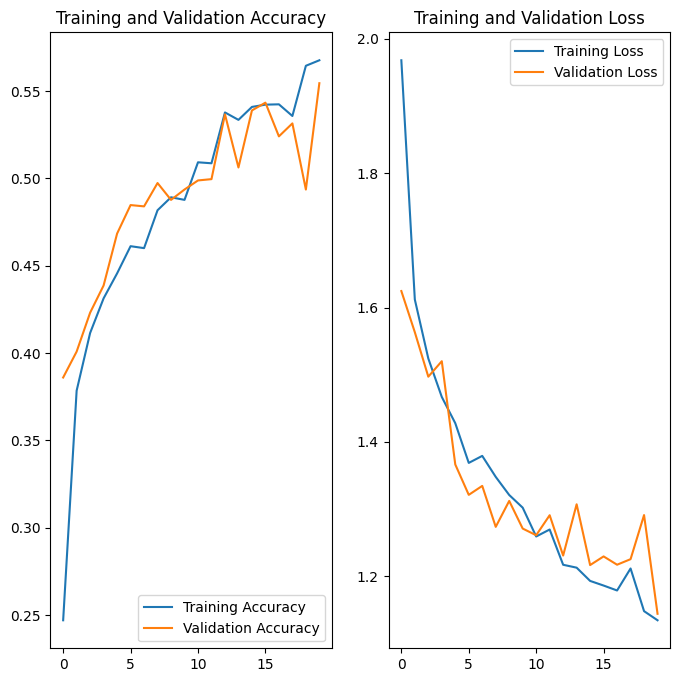

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Data augmentation and dropout helped us to overcome overfitting problem. However, we still need to work on improving our accuracy.

### Class imbalance (distribution of classes in the training dataset)
##### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [21]:
# count of images in each of the class. 

for i in class_names:
    directory =str(data_dir_train)+'/'+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


##### - Seborrheic keratosis has the least number of samples

##### - Pigmented benign keratosis dominate the data with approximately 6 times data as compared to Seborrheic keratosis. 


In [22]:
#Augmentor, a python package can help us to add more samples across all classes. It also help us to do image augmentation just like Keras layers and ImageDataGenerator
!pip install Augmentor
import Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
# # marked code inactive so that we do not generate new images everytime. 
# path_to_training_dataset= str(data_dir_train) + '/'

# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + i)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.zoom(probability=0.7, min_factor=1.1, max_factor=1.5)
#     p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F378F79F220>: 100%|██████████| 500/500 [00:33<00:00, 14.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F378F75C5B0>: 100%|██████████| 500/500 [00:30<00:00, 16.36 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F378F76F280>: 100%|██████████| 500/500 [00:24<00:00, 20.39 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F378F75E370>: 100%|██████████| 500/500 [01:55<00:00,  4.32 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F378F72E610>: 100%|██████████| 500/500 [01:52<00:00,  4.43 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F378F71C9A0>: 100%|██████████| 500/500 [00:24<00:00, 20.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F38D05FFE20>: 100%|██████████| 500/500 [00:58<00:00,  8.58 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F378E0C9220>: 100%|██████████| 500/500 [00:23<00:00, 20.92 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/SkinCancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F378F7FED00>: 100%|██████████| 500/500 [00:26<00:00, 19.02 Samples/s]


In [24]:
# total count of augmented images 
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [25]:
# Lets see the distribution of augmented data after adding new images to the original training data.

import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [26]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [27]:
for i in class_names:
    directory =str(data_dir_train)+'/'+i+'/'
    directory_out =str(data_dir_train)+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 1114 samples.
basal cell carcinoma has 1376 samples.
dermatofibroma has 1095 samples.
melanoma has 1438 samples.
nevus has 1357 samples.
pigmented benign keratosis has 1462 samples.
seborrheic keratosis has 1077 samples.
squamous cell carcinoma has 1181 samples.
vascular lesion has 1139 samples.


In [28]:
path_list_orig = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_orig = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [78]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [79]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [80]:
df2['Label'].value_counts()

vascular lesion               1000
squamous cell carcinoma       1000
nevus                         1000
actinic keratosis             1000
dermatofibroma                1000
seborrheic keratosis          1000
melanoma                      1000
basal cell carcinoma          1000
pigmented benign keratosis    1000
Name: Label, dtype: int64

So, now we have added 1000 images (500 * 2 times cell run) to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

In [34]:
# Defining the path for train and test images
train_path = '/content/drive/MyDrive/ColabNotebooks/SkinCancer/Train'
test_path = '/content/drive/MyDrive/ColabNotebooks/SkinCancer/Test'

# Update the paths to represent the train_path and test_path directory where images are located.
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [35]:
data_dir_train= pathlib.Path(train_path)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [37]:
# Create the model

model3 = Sequential([
normalization_layer,

layers.Conv2D(32, kernel_size = (2,2), activation='relu'),  #first convulational layer, default padding = 'same', 
layers.MaxPooling2D(),         # default poolsize = 2x2
layers.Dropout(0.10),          #Dropout layer with 10% Fraction of the input units to drop

layers.Conv2D(64, kernel_size = (2,2), activation='relu'),  #second convulational layer
layers.MaxPooling2D(),

layers.Conv2D(128, kernel_size = (2,2), activation='relu'),  #third convulational layer
layers.MaxPooling2D(),
layers.Dropout(0.10),          #Dropout layer with 10% Fraction of the input units to drop

layers.Flatten(),

layers.Dense(256, activation='relu'),    # dense layer
layers.Dropout(0.10),          #Dropout layer with 10% Fraction of the input units to drop

layers.Dense(128, activation='relu'),    # dense layer
layers.Dense(len(class_names), activation='softmax') # output layer, Softmax scales numbers/logits into probabilities.
])

#optimizer = optimizers.Adam(lr=learning_rate) # to change default learning rate 

# Compile
model3.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 179, 179, 32)      416       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 44, 44, 64)       0         
 2D)                                                  

In [39]:
#train the model
epochs = 20
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 59s 196ms/step - loss: 1.7690 - accuracy: 0.3233 - val_loss: 1.5527 - val_accuracy: 0.3890
Epoch 2/20
281/281 [==============================] - 56s 197ms/step - loss: 1.3724 - accuracy: 0.4713 - val_loss: 1.4130 - val_accuracy: 0.4855
Epoch 3/20
281/281 [==============================] - 54s 188ms/step - loss: 1.2098 - accuracy: 0.5418 - val_loss: 1.2048 - val_accuracy: 0.5291
Epoch 4/20
281/281 [==============================] - 54s 188ms/step - loss: 1.0074 - accuracy: 0.6183 - val_loss: 1.0189 - val_accuracy: 0.6328
Epoch 5/20
281/281 [==============================] - 53s 187ms/step - loss: 0.8791 - accuracy: 0.6706 - val_loss: 0.8804 - val_accuracy: 0.6805
Epoch 6/20
281/281 [==============================] - 60s 210ms/step - loss: 0.7060 - accuracy: 0.7364 - val_loss: 0.7561 - val_accuracy: 0.7361
Epoch 7/20
281/281 [==============================] - 64s 226ms/step - loss: 0.6057 - accuracy: 0.7702 - val_loss: 0.7340 - val_ac

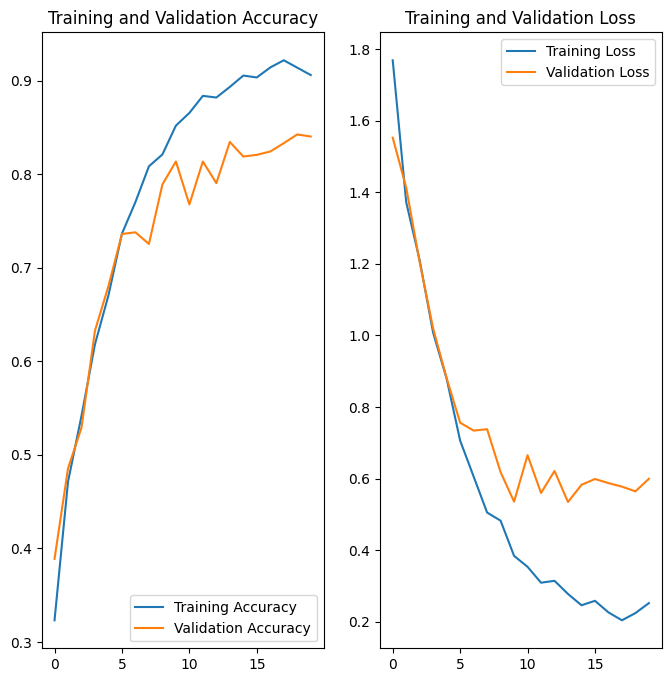

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

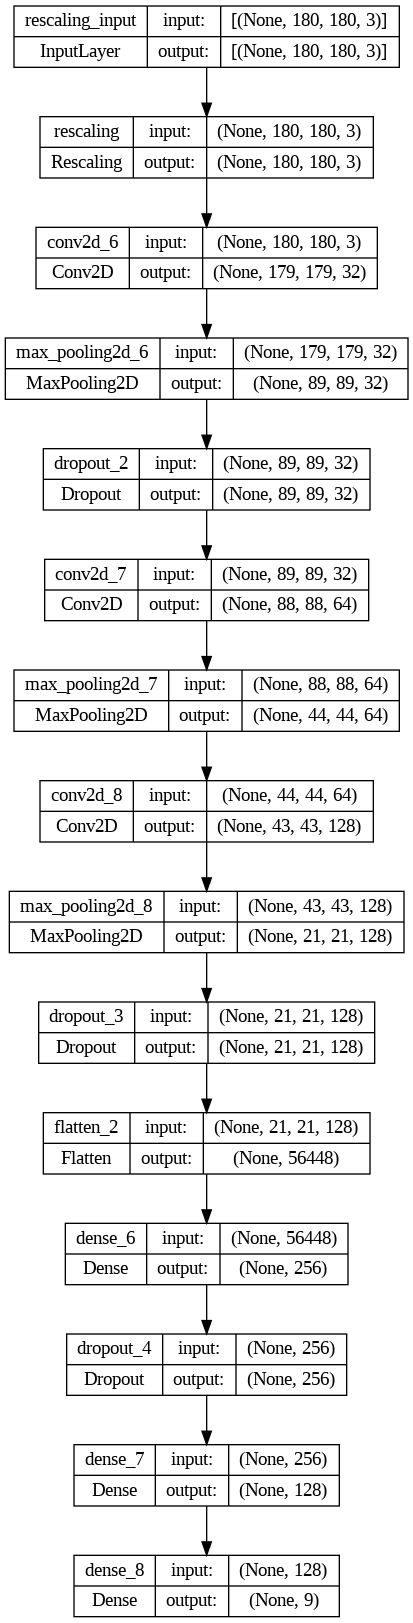

In [41]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Model Performance on unseen data



1/1 [==============================] - 0s 32ms/step
Actual Class vascular lesion
Predictive Class vascular lesion


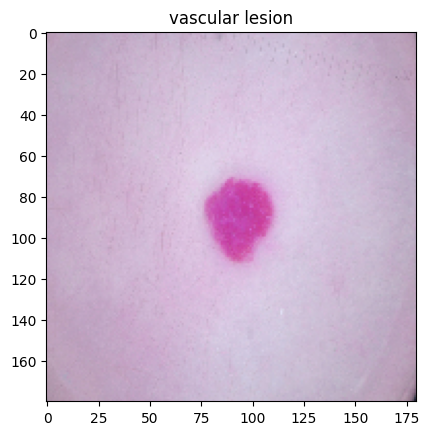

In [61]:
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[-1], '*')
Test_image = glob(Test_image_path) 
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.title(class_names[-1])
plt.grid(False)


img = np.expand_dims(Test_image,axis=0)
pred = model3.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[-1] +'\n'+ "Predictive Class "+pred_class )

1/1 [==============================] - 0s 63ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


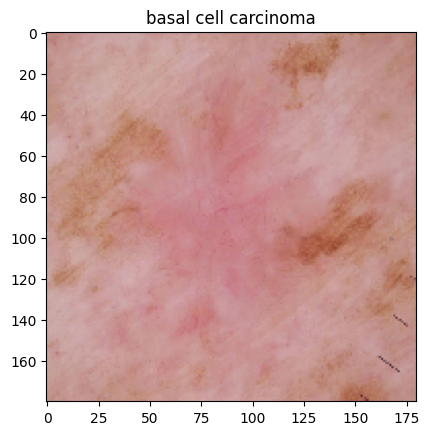

In [72]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path) 
Test_image = load_img(Test_image[1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.title(class_names[1])
plt.grid(False)


img = np.expand_dims(Test_image,axis=0)
pred = model3.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

1/1 [==============================] - 0s 31ms/step
Actual Class actinic keratosis
Predictive Class nevus


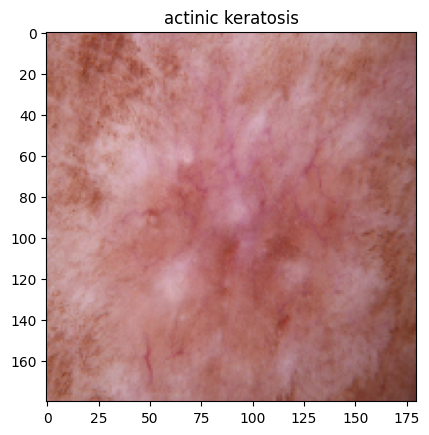

In [74]:
Test_image_path = os.path.join(data_dir_test, class_names[0], '*')
Test_image = glob(Test_image_path) 
Test_image = load_img(Test_image[0],target_size=(180,180,3))
plt.imshow(Test_image)
plt.title(class_names[0])
plt.grid(False)


img = np.expand_dims(Test_image,axis=0)
pred = model3.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[0] +'\n'+ "Predictive Class "+pred_class )


#incorrect classification - model accuracy - 84%

#### We can say that the above model3 has eradicated both the overfitting and underfitting problem. The rebalance using Augementor Module balanced each classes by adding augmented image by a fixed amount (here 500 * 2 (ran twice) to give equal importance to all the input classes. This model is a good fit with 84% accuracy on validation data.

#### I believe we can still improve a lot on this using Transfer learning (eg. with ResNET, VGG, Inception, AlexNet) or by adding more layers. However, due to limited computational resources I am not able to hypertune it. 